## Adversarial data augmentation
Adversarial data augmentation is the technique of traning the neural network for the second time with adversarial examples created for the specified network and getting a neural network that's more robust to adversarial examples

This demo is demonstrating how to frame the problem of finding adversarial examples into a optimization problem and solve them effectively.

## Adversarial data augmentation intuition
At a high level, neural network's hyperplane normally look something like this:

<img src="neural.png" alt="Drawing" style="width: 600px;"/>

Where the hyperplane is overfitting to the data, thus if we have a data point really close to the training data but moved in the spikes' direction, we will have a misclassification:

<img src="adversarial_example.png" alt="Drawing1" style="width: 600px;"/>

Thus, training on adversarial examples can kill off the spikes and make the decision boundary smooth, AKA large margin:

<img src="adversarial_training.png" alt="Drawing2" style="width: 600px;"/>

This is the basic intuition of adversarial data augmentation.

## load modules and pretrained 99.25% accuracy CNN

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

model = load_model('/Users/zetong/cnn.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## helper functions
Image loader, image visualization tools

In [3]:
# load the image from MNIST dataset into [1,28,28,1] dimension
def load_image(image_location):
    x = np.asarray(PIL.Image.open(image_location))
    x = x.reshape(28,28)
    x = x.reshape(1, 28, 28, 1)
    x = x.astype('float32')
    x /= 255
    return x

# putting the adversarial examples and their misclassification labels in subplots
def plot_adversarials(attacks, predicted_labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(str(predicted_labels[i-1]))
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    return

# a helper function to visualize a list of adversarial examples
def visualize_adversarials(attacks):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    return

## Carlini&Wagner L2 attack
The Carlini&Wagner attack is solving the following optimization problem:

$ min_w \left\lVert\frac{1}{2}(\tanh(w)+1-x)\right\lVert^2_2 + cf(\frac{1}{2}(\tanh(w)+1)$

where $f(x^{\prime})$ is defined as:

$f(x^{\prime}) = max(max({Z(x^{\prime}_i: i \neq t)} - Z(x^{\prime}_t)), -k)$

The relationship between $\delta$, w and x:

$\delta = \frac{1}{2}(\tanh(w)+1) - x$

Where $\delta$ is the noise, x is the original image, $\frac{1}{2}(\tanh(w)+1)$ is the adversarial example

In [8]:
class cwl2:
    def __init__(self, sess, model, K=0, max_iterations=1000, step_size=0.1, initial_cost=10, SEARCH_STEPS=9):
        self.sess = sess
        self.model = model
        self.K = K
        self.max_iterations = max_iterations
        self.step_size = step_size
        self.initial_cost = initial_cost
        self.SEARCH_STEPS = SEARCH_STEPS
        self.num_classes = 10
    
    # return the logits tensor and the nontarget index logits tensor
    def get_logits_and_nontarget_logits(self, x_new, target):
        logits = self.model(x_new)
        return logits, tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
    
    # the loss function for l2 attack
    def loss(self, x_new, x, target, c):
        logits, nontarget_logits = self.get_logits_and_nontarget_logits(x_new, target)
        return tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -self.K)
        
    # search for the best adversarial examples
    def find_best_attack(self, x, target, DEBUG=1):
        # all the valid attacks
        attacks = []
        # initial c value
        c = self.initial_cost
        # confidence parameter
        K = self.K
        # initialize all global variables
        self.sess.run(tf.global_variables_initializer())
        # for every search steps
        for s in range(self.SEARCH_STEPS):
            # the adversarial example the algorithm is searching for
            x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
            loss = self.loss(x_new, x, target, c)
            start_vars = set(x.name for x in tf.global_variables())
            train = tf.train.AdamOptimizer(self.step_size).minimize(loss, var_list=[x_new])
            end_vars = tf.global_variables()
            # variables in Adam optimizer
            new_vars = [x for x in end_vars if x.name not in start_vars]
            # initilize x_new and Adam optimizer variables
            self.sess.run(tf.variables_initializer(var_list=[x_new]+new_vars))
            
            for i in range(self.max_iterations):
                self.sess.run(train)
            new_img = self.sess.run(x_new)
            # if the attack is sucessful
            if np.argmax(self.model.predict(new_img)) == target:
                # add it to the valid attacks collection
                attacks.append(new_img)
                # decrease c value to try to find an attack with less perturbation
                c = c*0.5
            # if the attack failed
            else:
                # increase c value to enforce the solver to find a sucessful attack
                c = c*10
            # if debug mode, print out the each search step's detail
            if DEBUG == 1:
                print(s+1, "/", self.SEARCH_STEPS, "search steps")
                print("c value:", c)
                print(len(attacks), "adversarials examples found")
        # let the best attack to be the one with the smallest perturbation
        noise_norms = []
        for i in range(len(attacks)):
            noise_norms.append(np.linalg.norm(attacks[i] - x))
        best_attack = attacks[np.argmin(noise_norms)]
        return best_attack, attacks
    
    def untargeted_attack(self, x, true_label):
        attacks = []
        predicted_labels = []
        for i in range(self.num_classes):
            # don't need to find adversarial example for true label
            if i == true_label:
                continue
            print("attacking target label", i)
            best_attack, all_attacks = self.find_best_attack(x, i, DEBUG=0)
            attacks.append(best_attack)
            predicted_labels.append(np.argmax(self.model.predict(best_attack)))
            print(len(all_attacks), "attacks found")
        plot_adversarials(attacks, predicted_labels)
        return attacks

# attack demo

## Targeted attack demo:
find adversarial examples to miscalssify image 7 as 0

1 / 9 search steps
c value: 100
0 adversarials examples found
2 / 9 search steps
c value: 1000
0 adversarials examples found
3 / 9 search steps
c value: 500.0
1 adversarials examples found
4 / 9 search steps
c value: 250.0
2 adversarials examples found
5 / 9 search steps
c value: 125.0
3 adversarials examples found
6 / 9 search steps
c value: 62.5
4 adversarials examples found
7 / 9 search steps
c value: 625.0
4 adversarials examples found
8 / 9 search steps
c value: 312.5
5 adversarials examples found
9 / 9 search steps
c value: 3125.0
5 adversarials examples found


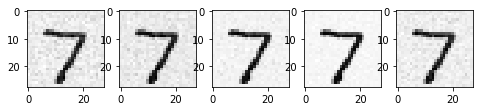

In [5]:
with tf.Session() as sess:
    x = load_image('/Users/zetong/mnist_png/testing/7/0.png')
    l2attack = cwl2(sess, model)
    best_attack, attacks = l2attack.find_best_attack(x, 0)
    visualize_adversarials(attacks)

## Untargeted attack demo
Find adversarial examples that misclassify image 4 from 0 to 9

attacking target label 0
6 attacks found
attacking target label 1
4 attacks found
attacking target label 2
9 attacks found
attacking target label 3
6 attacks found
attacking target label 5
5 attacks found
attacking target label 6
5 attacks found
attacking target label 7
4 attacks found
attacking target label 8
5 attacks found
attacking target label 9
6 attacks found


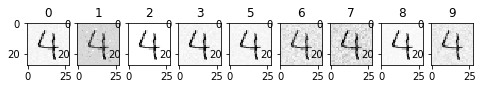

In [9]:
with tf.Session() as sess:
    x = load_image('/Users/zetong/mnist_png/testing/4/24.png')
    l2attack = cwl2(sess, model)
    attacks = l2attack.untargeted_attack(x, 4)